In [1]:
import gym
import torch

from src.Learner.WAC import WAC

from src.Learner.DQN import DQN
from src.Learner.Random import DiscreteRandomAgent
from src.nn.MLP import MLP, EnsembleNetwork, FNetwork
from src.utils.memory import ReplayMemory
from src.utils.train_utils import prepare_training_inputs

from gym.wrappers import RecordVideo
from IPython.display import HTML
import matplotlib.pyplot as plt

In [2]:
gamma = 0.9
memory_size = 500000

In [3]:
qnet = EnsembleNetwork(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = EnsembleNetwork(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
dual_critic = FNetwork(4, 1)
use_adv = True

agent = WAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi,
             dual_critic=dual_critic, 
             gamma=gamma, 
             lam=10, 
             num_action_samples=10,
             use_adv=use_adv,
             alpha=3
             )

In [4]:
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

## Prepare offline data

In [5]:
use_expert = True
if use_expert:    
    qnet = MLP(4, 2, num_neurons=[128])
    qnet_target = MLP(4, 2, num_neurons=[128])
    dqn = DQN(4, 1, qnet=qnet, qnet_target=qnet_target, lr=1e-4, gamma=gamma, epsilon=1.0)
    state_dict = torch.load('dqn_agent.pt')
    
    # make trained agent slightly dumb
    # to simulate the realistic scenario where we don't have 'perfect' policy
    # but good enough policy.
    
    state_dict['epsilon'] = dqn.epsilon * .4 
    dqn.load_state_dict(state_dict)    
    offline_agent = dqn
    offline_budget = 50
else:
    offline_agent = DiscreteRandomAgent(2)
    offline_budget = 300

online_budget = offline_budget

In [6]:
cum_rs = []
for n_epi in range(offline_budget):
    s, info = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = offline_agent.get_action(s)
        ns, r, term, trun, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(term).view(1, 1),
                      torch.tensor(trun).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if term or trun:
            cum_rs.append(cum_r)
            break

/tmp/ipykernel_151870/2192212026.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1731532454354/work/torch/csrc/utils/tensor_new.cpp:274.)
  s = torch.tensor((s,), dtype=torch.float)
/home/bms/anaconda3/envs/AWAC/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([0.01690141, 0.01126761, 0.00657277, 0.00375587, 0.00375587,
        0.00187793, 0.00187793, 0.        , 0.        , 0.00093897]),
 array([ 14. ,  35.3,  56.6,  77.9,  99.2, 120.5, 141.8, 163.1, 184.4,
        205.7, 227. ]),
 <BarContainer object of 10 artists>)

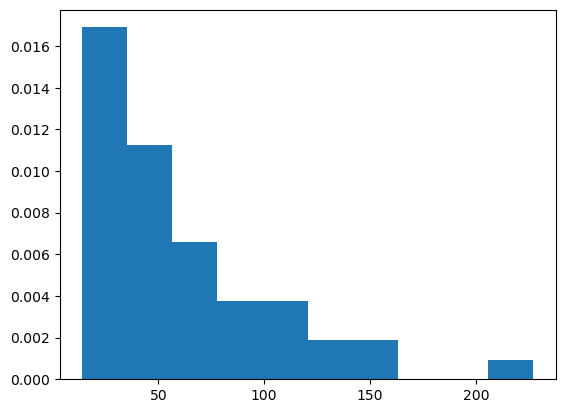

In [7]:
plt.hist(cum_rs, density=True, label='expert')

## offline training

In [8]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent.to(fit_device)
critic_losses, actor_losses, dual_critic_losses = [], [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    verbose = True if i % 1000 == 0 else False
    
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, term, trun = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)
    critic_loss = agent.update_critic(s,a,r,ns,term,trun,)
    actor_loss = agent.update_actor(s,a,i,n_updates,verbose)
    dual_critic_loss = agent.update_dual_critic(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())
    dual_critic_losses.append(dual_critic_loss.detach())        
agent.to('cpu')

fitting [0] / [8000]
sampled action: tensor([[0],
        [0],
        [0],
        [1],
        [1]], device='cuda:0')
p(a|s): tensor([[0.4950, 0.5050],
        [0.4958, 0.5042],
        [0.4853, 0.5147],
        [0.5162, 0.4838],
        [0.4923, 0.5077]], device='cuda:0', grad_fn=<SliceBackward0>) 
 Q: tensor([[-0.0349, -0.0476],
        [-0.0304, -0.0469],
        [-0.0715, -0.0322],
        [-0.0556, -0.0705],
        [-0.0490, -0.0431]], device='cuda:0', grad_fn=<SliceBackward0>)
loss: -0.03892844170331955 
 W: -0.0005856528878211975
fitting [1000] / [8000]
sampled action: tensor([[1],
        [0],
        [0],
        [0],
        [1]], device='cuda:0')
p(a|s): tensor([[0.4387, 0.5613],
        [0.4693, 0.5307],
        [0.3943, 0.6057],
        [0.9796, 0.0204],
        [0.3791, 0.6209]], device='cuda:0', grad_fn=<SliceBackward0>) 
 Q: tensor([[3.2145, 3.2075],
        [2.6413, 2.9701],
        [3.2708, 3.2247],
        [3.4177, 3.5600],
        [3.2939, 3.2117]], device='cuda:

WAC(
  (critic): EnsembleNetwork(
    (nets): ModuleList(
      (0-4): 5 x MLP(
        (hidden_act): ReLU()
        (out_act): Identity()
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=2, bias=True)
          (5): Identity()
        )
      )
    )
  )
  (critic_target): EnsembleNetwork(
    (nets): ModuleList(
      (0-4): 5 x MLP(
        (hidden_act): ReLU()
        (out_act): Identity()
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=2, bias=True)
          (5): Identity()
        )
      )
    )
  )
  (actor): MLP(
    (hidden_act): ReLU()
    (out_act): Identity

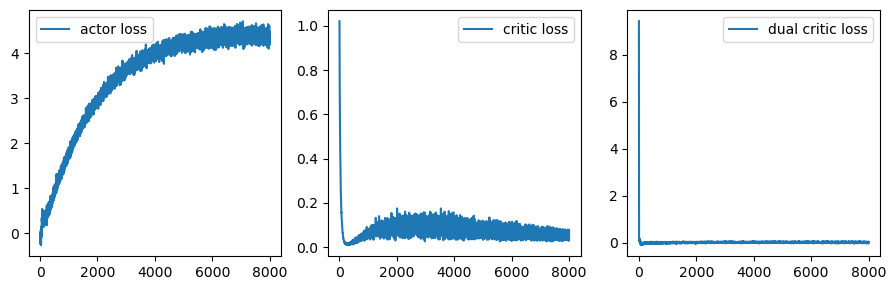

In [9]:
fig, axes = plt.subplots(1,3, figsize=(9,3))
axes[0].plot([loss.cpu().detach().numpy() for loss in actor_losses], label='actor loss')
axes[0].legend()
axes[1].plot([loss.cpu().detach().numpy() for loss in critic_losses], label='critic loss')
axes[1].legend()
axes[2].plot([loss.cpu().detach().numpy() for loss in dual_critic_losses], label='dual critic loss')
axes[2].legend()
fig.tight_layout()

## check offline perf

In [10]:
awac_cum_rs = []
num_runs = 500
for n_epi in range(num_runs):
    s, info = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, term, trun, info = env.step(a)

        s = ns
        cum_r += 1
        if term or trun:
            awac_cum_rs.append(cum_r)
            break

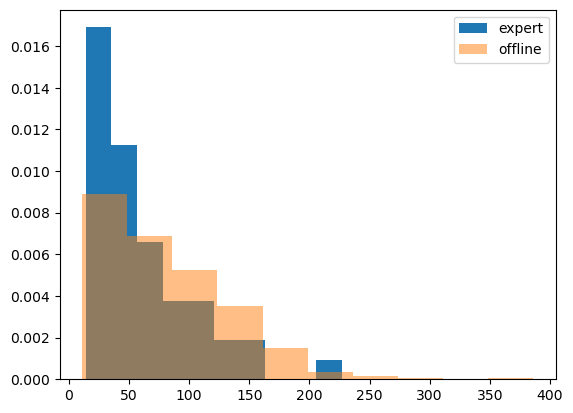

In [11]:
plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
plt.legend()

## Online fine tuning

In [12]:
agent.to('cpu')

WAC(
  (critic): EnsembleNetwork(
    (nets): ModuleList(
      (0-4): 5 x MLP(
        (hidden_act): ReLU()
        (out_act): Identity()
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=2, bias=True)
          (5): Identity()
        )
      )
    )
  )
  (critic_target): EnsembleNetwork(
    (nets): ModuleList(
      (0-4): 5 x MLP(
        (hidden_act): ReLU()
        (out_act): Identity()
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=2, bias=True)
          (5): Identity()
        )
      )
    )
  )
  (actor): MLP(
    (hidden_act): ReLU()
    (out_act): Identity

In [13]:
refresh_memory = False
if refresh_memory:
    memory.reset()

In [14]:
online_budget = 600
online_awac_cum_rs = []
for n_epi in range(online_budget):
    s, info = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, term, trun, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(term).view(1, 1),
                      torch.tensor(trun).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if term or trun:
            online_awac_cum_rs.append(cum_r)
            break
    
    if len(memory) >= batch_size:
        sampled_exps = memory.sample(batch_size)
        _s, _a, _r, _ns, _term, _trun = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_term,_trun)
        actor_loss = agent.update_actor(_s,_a, 1, 1)
        critic_losses.append(critic_loss.detach())
        actor_losses.append(actor_loss.detach())
        agent.to('cpu')

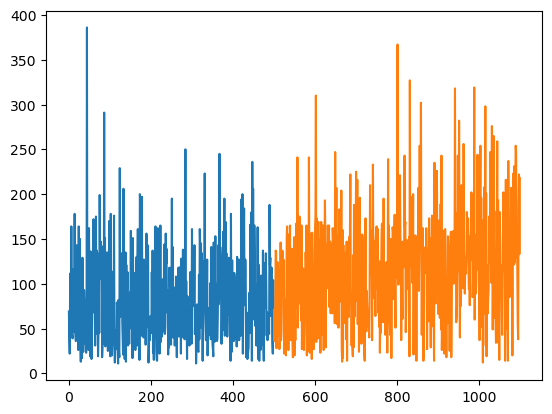

In [15]:
plt.plot(range(len(awac_cum_rs)), awac_cum_rs)
plt.plot(range(len(awac_cum_rs), 
               len(awac_cum_rs + online_awac_cum_rs)), 
         online_awac_cum_rs)

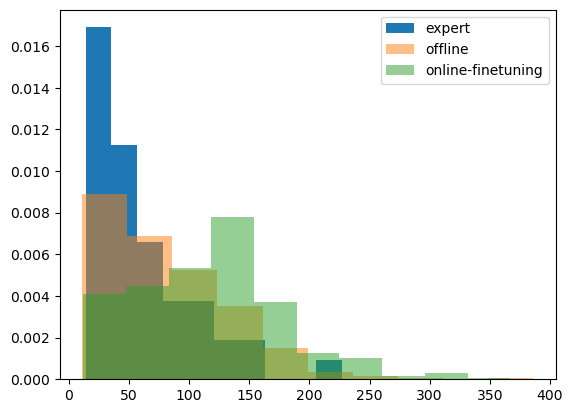

In [16]:
plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, alpha=0.5, density=True, label='offline')
plt.hist(online_awac_cum_rs, alpha=0.5, density=True, label='online-finetuning')
plt.legend()

In [35]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
env = gym.make("CartPole-v1", render_mode="rgb_array")
from IPython.display import Video

done = False
cum_r = 0
video = VideoRecorder(env, "WAC.mp4")
s, info = env.reset()
while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, term, trun, info = env.step(a)
        
        frame = env.render()
        video.capture_frame()
        s = ns
        cum_r += 1
        if term or trun:
            online_awac_cum_rs.append(cum_r)
            print(f"finished with reward: {cum_r}")
            break


env.close()
video.close()
video.enabled = False

Video("WAC.mp4", embed=True)



finished with reward: 226
MoviePy - Building video WAC.mp4.
MoviePy - Writing video WAC.mp4



MoviePy - Done !
MoviePy - video ready WAC.mp4
